# Retina Analysis

In [1]:
import scanpy as sc
import scvi
import anndata
from sklearn.cluster import KMeans

Global seed set to 0


In [2]:
adata=scvi.data.retina()

INFO     File /home/server_crash_/Single-Cell-Analysis/datasets/data/retina.loom already     
         downloaded                                                                          
INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["labels"]                                               
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 19829 cells, 13166 vars, 2        
         batches, 15 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [3]:
adata.obs

,labels,batch,_scvi_batch,_scvi_labels
0,BC5A,0.0,0,6
1,BC5C,0.0,0,8
2,BC6,0.0,0,10
3,RBC,0.0,0,14
4,BC1A,1.0,1,0
...,...,...,...,...
19824,RBC,0.0,0,14
19825,RBC,1.0,1,14
19826,BC1B,0.0,0,1
19827,BC1B,0.0,0,1


In [4]:
sc.pp.calculate_qc_metrics(adata,qc_vars=[],percent_top=[],log1p=False,inplace=True)

/home/server_crash_/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'labels' as categorical


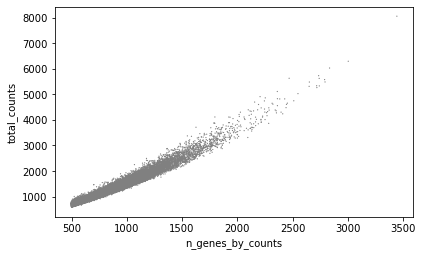

In [5]:
sc.pl.scatter(adata,"n_genes_by_counts","total_counts")

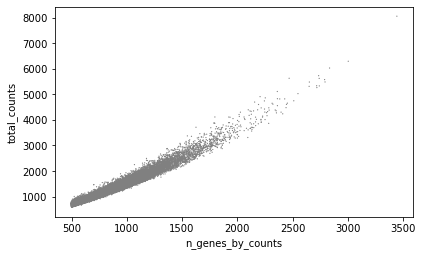

In [21]:
sc.pp.filter_cells(adata,max_counts=4000)
sc.pp.filter_cells(adata,max_genes=2000)
sc.pl.scatter(adata,"n_genes_by_counts","total_counts")

### Normalization

In [22]:
adata.layers["counts"]=adata.X.copy()
sc.pp.normalize_total(adata,target_sum=10000)
sc.pp.log1p(adata)
adata.raw=adata

In [23]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1500,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)

/home/server_crash_/.local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [24]:
adata.var
adata=adata[:,adata.var.highly_variable].copy()

In [25]:
#sc.pp.scale(adata)
sc.pp.pca(adata)

In [26]:
import scanpy.external as sce

In [27]:
sc.pp.neighbors(adata,n_neighbors=20)
sce.pp.bbknn(adata, batch_key="batch")

In [28]:
sc.tl.umap(adata)

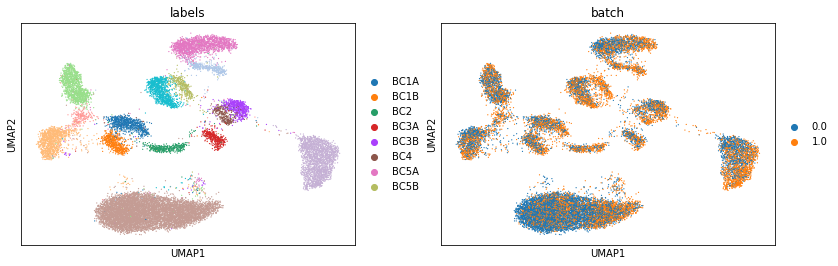

In [29]:
sc.pl.umap(adata, color=["labels","batch"])

In [30]:
adata.obs["labels"].value_counts()

RBC      8175
MG       2215
BC5A     1683
BC7      1312
BC6      1263
BC5C     1034
BC1A      835
BC3B      612
BC1B      585
BC2       420
BC3A      420
BC5D      402
BC5B      352
BC4       304
BC8_9     217
Name: labels, dtype: int64

In [124]:
X_pca = adata.obsm['X_pca'] 
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca) 
adata.obs['kmeans'] = kmeans.labels_.astype(str)


In [125]:
adata.obs


,labels,batch,_scvi_batch,_scvi_labels,n_genes_by_counts,total_counts,kmeans,n_counts,n_genes
0,BC5A,0.0,0,6,718,1010.0,10,190.527161,70
1,BC5C,0.0,0,8,707,923.0,13,178.022095,63
2,BC6,0.0,0,10,588,874.0,7,169.777939,59
3,RBC,0.0,0,14,693,1055.0,8,181.846649,65
4,BC1A,1.0,1,0,592,754.0,4,197.308563,68
...,...,...,...,...,...,...,...,...,...
19824,RBC,0.0,0,14,533,805.0,8,168.042145,53
19825,RBC,1.0,1,14,504,690.0,8,129.047440,41
19826,BC1B,0.0,0,1,562,720.0,4,221.389801,73
19827,BC1B,0.0,0,1,791,1183.0,4,250.969894,94


/home/server_crash_/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


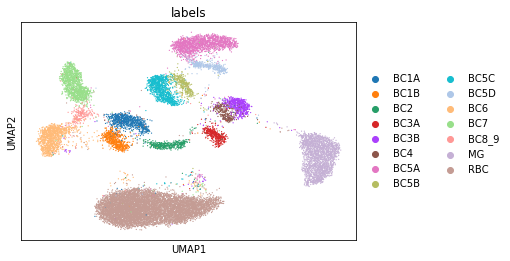

In [126]:
sc.pl.umap(adata,color="labels")

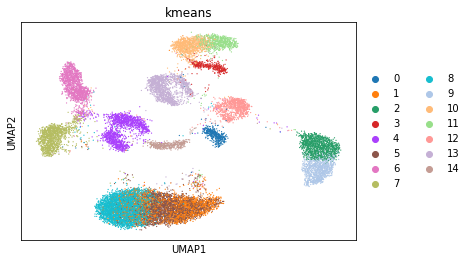

In [127]:
sc.pl.umap(adata,color=['kmeans'])

In [128]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score
print("NMI is: ",normalized_mutual_info_score(adata.obs["labels"],adata.obs['kmeans']))
print("ARI is: ",adjusted_rand_score(adata.obs["labels"],adata.obs['kmeans']))
print("FM is: ",fowlkes_mallows_score(adata.obs["labels"],adata.obs['kmeans']))

NMI is:  0.7879641803205761
ARI is:  0.4961859291361182
FM is:  0.6055960934116031


#### N=15 (Number of unique ground truth)
NMI is:  0.7879641803205761  
ARI is:  0.4961859291361182  
FM is:  0.6055960934116031

#### N=9
NMI is:  0.8116944630344897  
ARI is:  0.6617286911689038  
FM is:  0.7300561185402626  

*It gives better result than N=15*